In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm

import rebound
import scipy.stats as stats
from astroML.stats import binned_statistic_2d
from scipy.optimize import minimize
%matplotlib inline

In [162]:
#dataframe 
df = pd.read_csv("exoplanet.eu_catalog.csv",dtype={"# name": str, "star_name": str, "star_sp_type": str});df

,# name,planet_status,mass,mass_error_min,mass_error_max,mass_sini,mass_sini_error_min,mass_sini_error_max,radius,radius_error_min,...,star_sp_type,star_age,star_age_error_min,star_age_error_max,star_teff,star_teff_error_min,star_teff_error_max,star_detected_disc,star_magnetic_field,star_alternate_names
0,11 Com b,Confirmed,19.40000,1.50000,1.500000,19.40000,1.50000,1.50000,NaN,NaN,...,G8 III,NaN,NaN,NaN,4742.0,100.0,100.0,NaN,NaN,NaN
1,11 Oph b,Confirmed,21.00000,3.00000,3.000000,NaN,NaN,NaN,NaN,NaN,...,M9,0.011,0.002,0.002,2375.0,175.0,175.0,NaN,NaN,"Oph 11A, Oph 1622-2405"
2,11 UMi b,Confirmed,10.50000,2.47000,2.470000,10.50000,2.47000,2.47000,NaN,NaN,...,K4III,1.560,0.540,0.540,4340.0,70.0,70.0,NaN,NaN,NaN
3,14 And b,Confirmed,5.33000,0.57000,0.570000,5.33000,0.57000,0.57000,NaN,NaN,...,K0III,NaN,NaN,NaN,4813.0,20.0,20.0,NaN,NaN,NaN
4,14 Her b,Confirmed,4.64000,0.19000,0.190000,4.64000,0.19000,0.19000,NaN,NaN,...,K0 V,5.100,NaN,NaN,5311.0,87.0,87.0,NaN,NaN,NaN
5,16 Cyg B b,Confirmed,1.68000,0.07000,0.070000,1.68000,0.07000,0.07000,NaN,NaN,...,G2.5 V,8.000,1.800,1.800,5766.0,60.0,60.0,NaN,NaN,NaN
6,18 Del b,Confirmed,10.30000,NaN,NaN,10.30000,NaN,NaN,NaN,NaN,...,G6III,NaN,NaN,NaN,4979.0,18.0,18.0,NaN,NaN,NaN
7,1RXS 1609 b,Confirmed,14.00000,3.00000,2.000000,NaN,NaN,NaN,1.7000,NaN,...,K7V,0.011,0.002,0.002,4060.0,200.0,200.0,NaN,NaN,"1RXS J160929, 1RXS J1609, 1RXS1609"
8,1RXS J235133.3+312720 b,Confirmed,32.00000,6.00000,6.000000,NaN,NaN,NaN,NaN,NaN,...,M2V,0.100,0.050,0.050,NaN,NaN,NaN,NaN,NaN,2MASS J23513366+3127229
9,1SWASP J1407 b,Confirmed,20.00000,6.00000,6.000000,20.00000,6.00000,6.00000,NaN,NaN,...,NaN,0.016,NaN,NaN,4400.0,100.0,100.0,NaN,NaN,NaN


In [163]:
 #initial detection types
det_type = df.loc[:,'detection_type']

im = df[det_type == 'Imaging']
rv = df[det_type == 'Radial Velocity']
tt = df[det_type == 'TTV']
pt = df[det_type == 'Primary Transit']
ml = df[det_type == 'Microlensing']
st = df[det_type == 'Primary Transit, TTV'] 

#definig planet limits
hj_p_cut = df['orbital_period'] <= 10 #HJs; < 10 day periods 
j_m_cut = df['mass'] >= 0.25         #Jupiters; > 0.25 M_j masses
hj_pm_cut = (df['orbital_period'] <=10) & (df['mass'] >= 0.24) #Jupiters, > 0.25 M_j & < 10 day periods 

#planet parameters, fill NaN 
period = df['orbital_period'].fillna(-999)
ecc = df['eccentricity'].fillna(-999)
inc = df['inclination'].fillna(-999)
a = df['semi_major_axis'].fillna(-999)
omega = df['omega'].fillna(-999)
rp = df['radius'].fillna(-999)
mp = df['mass'].fillna(-999)
mp_i = df['mass_sini'].fillna(-999)

#stellar parameters, fill NaN
obl = df['lambda_angle'].fillna(-999)
feh = df['star_metallicity'].fillna(-999)
teff = df['star_teff'].fillna(-999)
age = df['star_age'].fillna(-999)
rstar = df['star_radius'].fillna(-999)
mstar = df['star_mass'].fillna(-999)

def jup_2_sun(jup_mass):
    solar_mass = jup_mass * 9.5458E-4
    return solar_mass
def ter_2_sun(ter_mass):
    solar_mass = ter_mass * 3.003467E-6
    return solar_mass

In [5]:
def plot_census():
    fig = plt.figure(figsize=(7,10))
    fig.subplots_adjust(wspace=0.25, left=0.1, right=0.95, bottom=0.07, top=0.95)
    plt.subplot(211)
    plt.loglog(rv.semi_major_axis,rv.mass_sini,"s",alpha=0.5,label="Doppler")
    plt.loglog(pt.semi_major_axis,pt.mass,"^",alpha=0.5,label="Transit")
    plt.loglog(ml.semi_major_axis,ml.mass,"o",alpha=0.5,label="Microlensing")
    plt.loglog(im.semi_major_axis,im.mass,"d",alpha=0.5, label="Imaging")
    plt.loglog(tt.semi_major_axis,tt.mass,"v",alpha=1,label="TTV")
    plt.loglog(st.semi_major_axis,st.mass,"^",alpha=0.5,label="")
    plt.loglog(5.2,1,'k.') #Jupiter
    plt.text(8,0.75, 'Jupiter', fontsize=10)
    plt.ylabel("Planet Mass [$M_{Jup}$]")
    plt.xlabel("Semi-Major Axis [AU]")
    plt.title('Extra-solar Planet Census Parameters')
    plt.legend()
    plt.subplot(212)
    plt.loglog(rv.orbital_period,rv.mass_sini,"s",alpha=0.5,label="Doppler")
    plt.loglog(pt.orbital_period,pt.mass,"^",alpha=0.5,label="Transit")
    plt.loglog(ml.orbital_period,ml.mass,"o",alpha=0.5,label="Microlensing")
    plt.loglog(im.orbital_period,im.mass,"d",alpha=0.5, label="Imaging")
    plt.loglog(tt.orbital_period,tt.mass,"v",alpha=1,label="TTV")
    plt.loglog(st.orbital_period,st.mass,"^",alpha=0.5,label="")
    plt.loglog(4300,1,'k.') #Jupiter
    plt.text(9100,0.75, 'Jupiter', fontsize=10)
    plt.axvline(x = 10, color = 'k',linestyle = '--')
    plt.axhline(y = 0.25, color = 'k', alpha = 0.5,linestyle = '--')
    plt.xlabel("Orbital Period [days]")
    plt.ylabel("Planet Mass [$M_{Jup}$]")
    plt.legend()
    plt.title('Exoplanet Census with Hot Jupiter Limits')

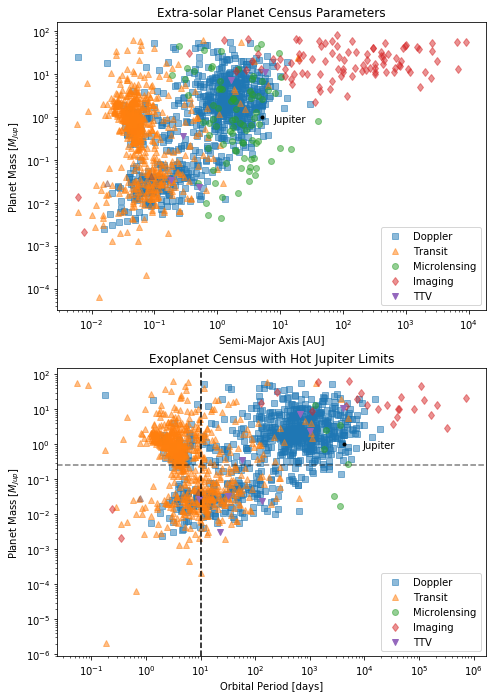

In [5]:
plot_census()
#plt.savefig("census.pdf")

(0.01, 5)

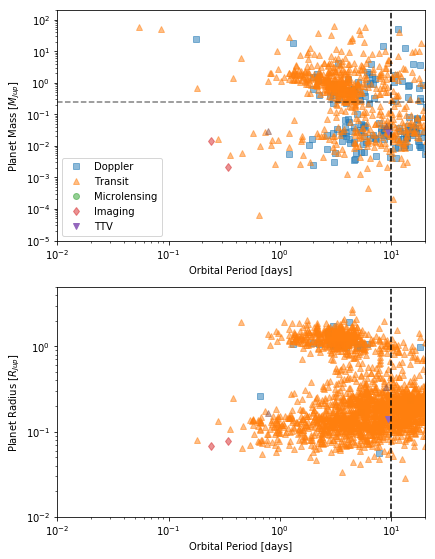

In [36]:
fig = plt.figure(figsize=(6,8))
fig.subplots_adjust(wspace=0.25, left=0.1, right=0.95, bottom=0.07, top=0.95)
plt.subplot(211)
plt.loglog(rv.orbital_period,rv.mass_sini,"s",alpha=0.5,label="Doppler")
plt.loglog(pt.orbital_period,pt.mass,"^",alpha=0.5,label="Transit")
plt.loglog(ml.orbital_period,ml.mass,"o",alpha=0.5,label="Microlensing")
plt.loglog(im.orbital_period,im.mass,"d",alpha=0.5, label="Imaging")
plt.loglog(tt.orbital_period,tt.mass,"v",alpha=1,label="TTV")
plt.loglog(st.orbital_period,st.mass,"^",alpha=0.5,label="")
plt.axvline(x = 10, color = 'k',linestyle = '--')
plt.axhline(y = 0.25, color = 'k', alpha = 0.5,linestyle = '--')
#plt.legend()
plt.xlabel("Orbital Period [days]")
plt.ylabel("Planet Mass [$M_{Jup}$]")
plt.xlim(0.01, 20)
plt.ylim(0.00001,200)
plt.subplot(212)
plt.loglog(rv["orbital_period"],rv["radius"],"s",alpha=0.5,label="Doppler")
plt.loglog(pt["orbital_period"],pt["radius"],"^",alpha=0.5,label="Transit")
plt.loglog(ml["orbital_period"],ml["radius"],"o",alpha=0.5,label="Microlensing")
plt.loglog(im["orbital_period"],im["radius"],"d",alpha=0.5, label="Imaging")
plt.loglog(tt["orbital_period"],tt["radius"],"v",alpha=1,label="TTV")
plt.loglog(st["orbital_period"],st["radius"],"^",alpha=0.5,label="")
plt.axvline(x = 10, color = 'k',linestyle = '--')
plt.xlabel("Orbital Period [days]")
plt.ylabel("Planet Radius [$R_{Jup}$]")
plt.xlim(0.01, 20)
plt.ylim(0.01,5)

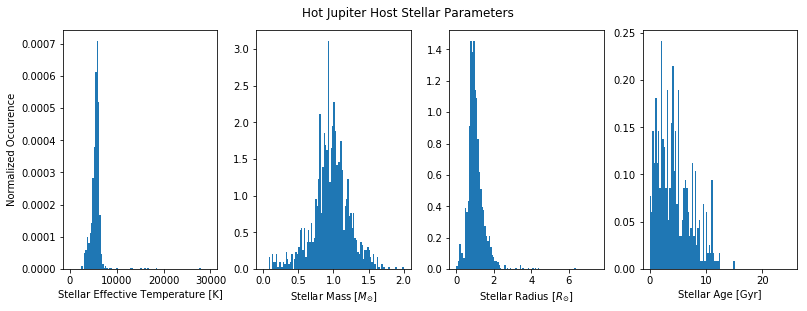

In [260]:
def plot_HJ_star_params():
    fig = plt.figure(figsize=(12,4))
    fig.subplots_adjust(wspace=0.25, left=0.1, right=0.95, bottom=0.07, top=0.9)
    plt.subplot(141)
    plt.hist(teff.loc[df["orbital_period"] < 10].dropna(),bins=100,range=(0,30000),density=True)
    #plt.axvline(x = 6250, color = 'k')
    plt.xlabel("Stellar Effective Temperature [K]")
    plt.ylabel("Normalized Occurence")
    plt.subplot(142)
    plt.hist(mstar.loc[df["orbital_period"] < 10].dropna(),bins=100,range=(0,2),density=True)
    plt.xlabel("Stellar Mass [$M_{\odot}$]")
    plt.subplot(143)
    plt.hist(rstar.loc[df["orbital_period"] < 10].dropna(),bins=100,range=(0,7.5),density=True)
    plt.xlabel("Stellar Radius [$R_{\odot}$]")
    plt.subplot(144)
    plt.hist(age.loc[df["orbital_period"] < 10].dropna(),bins=100,range=(0,25),density=True)
    plt.xlabel("Stellar Age [Gyr]")
    plt.suptitle("Hot Jupiter Host Stellar Parameters")
plot_HJ_star_params(); #plt.savefig('star_params.pdf')

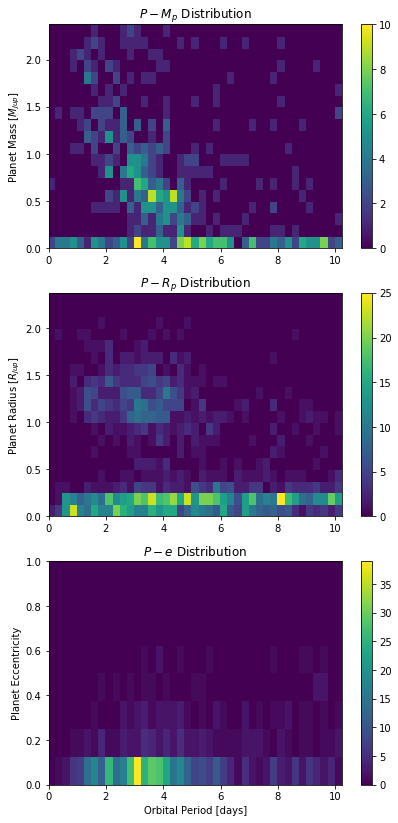

In [211]:
def planet_distribution(p_max):
    bin_size = 0.5
    period_bins = np.arange(0, p_max + bin_size, bin_size/2)
    period_range = (0,p_max) #HJ
    mp_bins = np.arange(0,2 + bin_size, bin_size/4)
    mp_range = (0,2)
    rp_bins = np.arange(0,2 + bin_size, bin_size/4)
    rp_range = (0,2)
    ecc_bins = np.arange(0,0.6+bin_size,bin_size/4)
    ecc_range = (0,1)

    #period-mass
    pm_hist,period_bins,mp_bins=np.histogram2d(period,mp,bins=(period_bins,mp_bins),range=(period_range,mp_range))
    pm_hist = pm_hist.T
    #period-radius
    pr_hist,period_bins,rp_bins=np.histogram2d(period,rp,bins=(period_bins,rp_bins),range=(period_range,rp_range))
    pr_hist = pr_hist.T    
    #period-eccentricity
    pe_hist,period_bins,ecc_bins=np.histogram2d(period,ecc,bins=(period_bins,ecc_bins),range=(period_range,ecc_range))
    pe_hist = pe_hist.T

    fig = plt.figure(figsize=(6,12))
    fig.subplots_adjust(wspace=0.25, left=0.1, right=0.95, bottom=0.07, top=0.95)
    #plt.suptitle("Hot Jupiter Distributions")
    plt.subplot(311, title = '$P-M_{p}$ Distribution')
    #plt.xlabel("Orbital Period [days]")
    plt.ylabel("Planet Mass [$M_{Jup}$]")
    im1 = plt.pcolormesh(*np.meshgrid(period_bins, mp_bins), pm_hist)
    plt.colorbar(im1)
    plt.subplot(312, title = '$P-R_{p}$ Distribution')
    #plt.ylabel("Sky Projected Obliquity [deg]")
    #plt.xlabel("Orbital Period [days]")
    plt.ylabel("Planet Radius [$R_{Jup}$]")
    im2 = plt.pcolormesh(*np.meshgrid(period_bins, rp_bins), pr_hist)
    plt.colorbar(im2)
    plt.subplot(313, title = '$P-e$ Distribution')
    #plt.ylabel("Sky Projected Obliquity [deg]")
    plt.xlabel("Orbital Period [days]")
    plt.ylabel("Planet Eccentricity")
    im3 = plt.pcolormesh(*np.meshgrid(period_bins, ecc_bins), pe_hist)
    plt.colorbar(im3)
planet_distribution(10)
#plt.savefig('planet_dist.pdf')

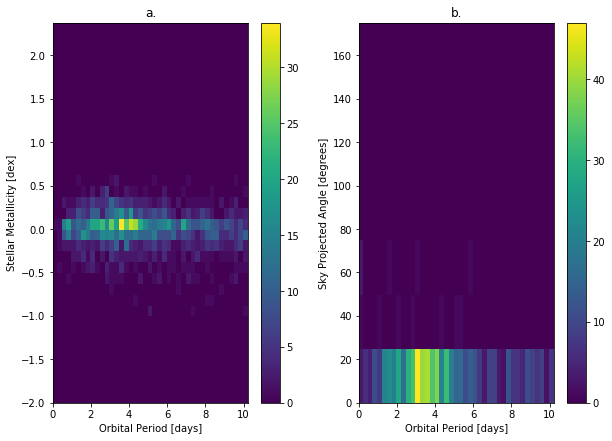

In [212]:
def star_distribution(p_max):
    bin_size = 0.5
    period_bins = np.arange(0, p_max + bin_size, bin_size/2)
    period_range = (0,p_max) #HJ
    feh_bins = np.arange(-2,2 + bin_size, bin_size/4)
    feh_range = (-2,2)
    rp_bins = np.arange(0,2 + bin_size, bin_size/4)
    rp_range = (0,2)
    obl_bins = np.arange(0,180+bin_size,bin_size*50)
    obl_range = (0,180)
    #period-feh
    pf_hist,period_bins,feh_bins=np.histogram2d(period,feh,bins=(period_bins,feh_bins),range=(period_range,feh_range))
    pf_hist = pf_hist.T 
    #period-obliquity
    po_hist,period_bins,obl_bins=np.histogram2d(period,mp,bins=(period_bins,obl_bins),range=(period_range,obl_range))
    po_hist = po_hist.T
    
    fig = plt.figure(figsize=(9,6))
    fig.subplots_adjust(wspace=0.25, left=0.1, right=0.95, bottom=0.07, top=0.95)
    plt.subplot(121, title = 'a.')
    plt.xlabel("Orbital Period [days]")
    plt.ylabel("Stellar Metallicity [dex]")
    im1 = plt.pcolormesh(*np.meshgrid(period_bins, feh_bins), pf_hist)
    plt.colorbar(im1)
    plt.subplot(122, title = 'b.')
    #plt.ylabel("Sky Projected Obliquity [deg]")
    plt.xlabel("Orbital Period [days]")
    plt.ylabel("Sky Projected Angle [degrees]")
    im2 = plt.pcolormesh(*np.meshgrid(period_bins, obl_bins), po_hist)
    plt.colorbar(im2)
star_distribution(10)
#plt.savefig('star_dist.pdf')

In [101]:
def rand_powerlaw(slope, min_v, max_v):
    y = np.random.uniform()
    pow_max = pow(max_v, slope+1.)
    pow_min = pow(min_v, slope+1.)
    return pow((pow_max-pow_min)*y + pow_min, 1./(slope+1.))

def rand_uniform(minimum, maximum):
    return np.random.uniform()*(maximum-minimum)+minimum

def rand_rayleigh(sigma):
    return sigma*np.sqrt(-2*np.log(np.random.uniform()))

def r_hill(mp,mout,mstar,a): #hill radius
    r_hill = ((mp + mout)/3*mstar)**(1/3)
    return r_hill

def run_sim_disk(a_disk,a_in,mp,Noutputs): 
    #simulation of proto disk; maximum a_disk AU, planet at a_in AU
    sim = rebound.Simulation()
    sim.units = ('AU','yr', 'Msun')
    #integrator options
    sim.integrator = "mercurius"
    sim.dt = 1e-3
    sim.testparticle_type = 1
    sim.ri_ias15.min_dt = 1e-6 
    #ensure that close encounters do not stall the integration

    #collision and boundary options
    sim.collision = "direct"
    sim.collision_resolve = "merge"
    sim.collision_resolve_keep_sorted = 1
    sim.boundary = "open"
    boxsize = 200.
    sim.configure_box(boxsize)
    sim.track_energy_offset = 1
    
    times = np.linspace(0,1000000,Noutputs)
    
    sim.add(m=1.)
    sim.add(m=mp,r=r_hill(mp,0,1,a_in),a=a_in,e=0.01)
    sim.N_active = sim.N   # sim.N= 2
    
    N_pl = 500                        # Number of bodies in disk
    
    np.random.seed(42) 
    # by setting a seed will reproduce the same simulation every time
    while sim.N < (N_pl + sim.N_active):
        a = rand_powerlaw(0, 0.01,a_disk)
        e = rand_rayleigh(0.01)
        inc = rand_rayleigh(0.05)
        r = rand_uniform(1e-7,1e-5)
        m = rand_uniform(1e-10,1e-5)
        rand = rand_uniform(2,2*np.pi)
        p = rebound.Particle(simulation=sim,primary=sim.particles[0],m=m,r=r,a=a,e=e,inc=inc,Omega=rand,omega=rand)
        sim.add(p)

    sim.move_to_com()
    E0 = sim.calculate_energy()
    fig = rebound.OrbitPlot(sim,Narc=300)
    
    ecc = np.zeros(Noutputs)
    a = np.zeros(Noutputs)
    inc = np.zeros(Noutputs)
    m = np.zeros(Noutputs)
    
    for i,time in enumerate(times):
        sim.integrate(time, exact_finish_time=0)
        a[i] = sim.particles[1].a
        ecc[i] = sim.particles[1].e
        inc[i] = sim.particles[1].inc
        m[i] = sim.particles[1].m
    return times, a, ecc, inc, m

In [225]:
def run_sim(a_out,a_in,mp,Noutputs,e_out,e_in,i_out,i_in): 
    #simulation of 2-planet system; 
    #outer planet at a_out AU with e_out and i_out
    #inner planet at a_in AU with e_in and i_in
    sim = rebound.Simulation()
    sim.units = ('AU','yr', 'Msun')
    times = np.linspace(0,1000000,Noutputs)
    sim.integrator = "whfast"
    sim.dt = 1e-3

    sim.add(m=1.)
    sim.add(primary=sim.particles[0],m=mp,r=r_hill(mp,0,.001,a_in),a=a_in,e=e_in,inc=(i_in*np.pi/180))
    sim.add(primary=sim.particles[0],m=0.001,r=r_hill(0.001,mp,1,a_out),a=a_out,e=e_out,inc=(i_out*np.pi/180))
    
    sim.move_to_com()
    E0 = sim.calculate_energy()
    fig = rebound.OrbitPlot(sim,Narc=300)
    
    x = np.zeros((2,Noutputs))
    ecc = np.zeros((2,Noutputs))
    a = np.zeros((2,Noutputs))
    inc = np.zeros((2,Noutputs))
    
    for i,time in enumerate(times):
        sim.integrate(time, exact_finish_time=0)
        a[0][i] = sim.particles[1].a
        ecc[0][i] = sim.particles[1].e
        inc[0][i] = sim.particles[1].inc
        x[0][i] = sim.particles[1].x
        x[1][i] = sim.particles[2].x
        a[1][i] = sim.particles[2].a
        ecc[1][i] = sim.particles[2].e
        inc[1][i] = sim.particles[2].inc
    return times, a[0], ecc[0], inc[0], a[1], ecc[1], inc[1]

def run_sim_var(a_out,a_in,mp,Noutputs): 
    #simulation of 2-planet system; 
    #varying outer planet a_out, inner planet a_in
    sim = rebound.Simulation()
    sim.units = ('AU','yr', 'Msun')
    times = np.linspace(0,1000000,Noutputs)
    sim.integrator = "whfast"
    sim.dt = 1e-3
    
    sim.add(m=1.)
    sim.add(primary=sim.particles[0],m=mp,r=r_hill(mp,0,.001,a_in),a=a_in,e=0.01)
    sim.add(primary=sim.particles[0],m=0.001,r=r_hill(0.001,mp,1,a_out),a=a_out)
    var_da = sim.add_variation()
    var_dda = sim.add_variation(order=2, first_order=var_da)
    var_da.vary(2, "a")
    var_dda.vary(2, "a")
    sim.move_to_com()

    x = np.zeros(Noutputs)
    dx = np.zeros(Noutputs)
    ddx = np.zeros(Noutputs)
    
    for i,time in enumerate(times):
        sim.integrate(time, exact_finish_time=0)
        x[i] = sim.particles[1].x
        dx[i] = var_da.particles[1].x
        ddx[i] = var_dda.particles[1].x
    return x,dx,ddx

In [226]:
def plot_sim_disk(a_disk,a_in,mp,Noutputs):
    sim = run_sim_disk(a_disk,a_in,mp,Noutputs)
    times = sim[0]/1000000; a = sim[1]; ecc = sim[2]; inc = sim[3]*180/np.pi
    fig = plt.figure(figsize=(10,6))
    fig.subplots_adjust(wspace=0.25, left=0.1, right=0.95, bottom=0.07, top=0.95)
    plt.subplot(311)
    plt.ylabel("Inclination")
    plt.plot(times, inc)
    plt.subplot(312)
    plt.ylabel("Eccentricity")
    plt.plot(times, ecc)
    plt.subplot(313)
    plt.xlabel("time [Myr]")
    plt.ylabel("Semi-major axis [AU]")
    plt.plot(times, a)

    
def plot_sim(a_out,a_in,mp,Noutputs,e_out,e_in,i_out,i_in):
    sim = run_sim(a_out,a_in,mp,Noutputs,e_out,e_in,i_out,i_in)
    times = sim[0]/1000000
    a1 = sim[1]; ecc1 = sim[2]; inc1 = sim[3]*180/np.pi #inner planet
    a2 = sim[4]; ecc2 = sim[4]; inc2 = sim[6]*180/np.pi #outer planet
    fig = plt.figure(figsize=(10,8))
    fig.subplots_adjust(wspace=0.25, left=0.1, right=0.95, bottom=0.07, top=0.95)
    plt.subplot(311)
    plt.ylabel("Inclination")
    plt.plot(times, inc1, label ='inner planet')
    plt.plot(times, inc2, label ='outer planet')
    plt.legend()
    plt.subplot(312)
    plt.ylabel("Eccentricity")
    plt.plot(times, ecc1,label ='inner planet')
    plt.plot(times, ecc2,label ='outer planet')
    plt.legend()
    plt.subplot(313)
    plt.xlabel("time [Myr]")
    plt.ylabel("Semi-major axis [AU]")
    plt.plot(times, a1, label ='inner planet')
    plt.plot(times, a2, label ='outer planet')
    plt.legend()

    
def plot_sim_var(a_0,a_in,mp,Noutputs): 
    #outer planet at initial a_0 AU; varying a_out
    x_exact = np.zeros((Noutputs))
    a_grid = np.linspace(5,10,Noutputs)
    x, dxda, ddxdda = run_sim_var(a_0,a_in,mp,Noutputs)
    x_1st_order = np.zeros(Noutputs)
    x_2nd_order = np.zeros(Noutputs)
    for i,a in enumerate(a_grid):
        x_exact[i] = run_sim(a,2,mp,Noutputs)[4]
        x_1st_order[i] = x + (a-a_0)*dxda
        x_2nd_order[i] = x + (a-a_0)*dxda + 0.5*(a-a_0)*(a-a_0)*ddxdda

    fig = plt.figure(figsize=(9,6))
    fig.subplots_adjust(wspace=0.25, left=0.1, right=0.95, bottom=0.07, top=0.95)
    plt.subplot(111)
    plt.xlim(a_grid[0],a_grid[-1])
    plt.ylim(0,np.max(x_exact)*1.01)
    plt.xlabel("initial semi-major axis of the outer planet")
    plt.ylabel("$x$ position of inner planet" ) #how many orbits
    plt.plot(a_grid, x_exact, "-", color="black", lw=2)
    plt.plot(a_grid, x_1st_order, "--", color="green")
    plt.plot(a_grid, x_2nd_order, ":", color="blue")
    plt.plot(a_0, x, "ro",ms=10);

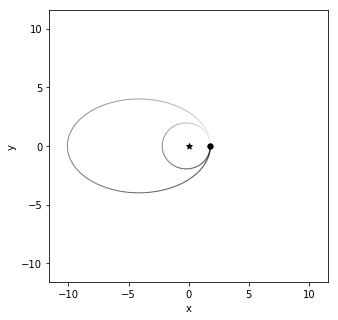

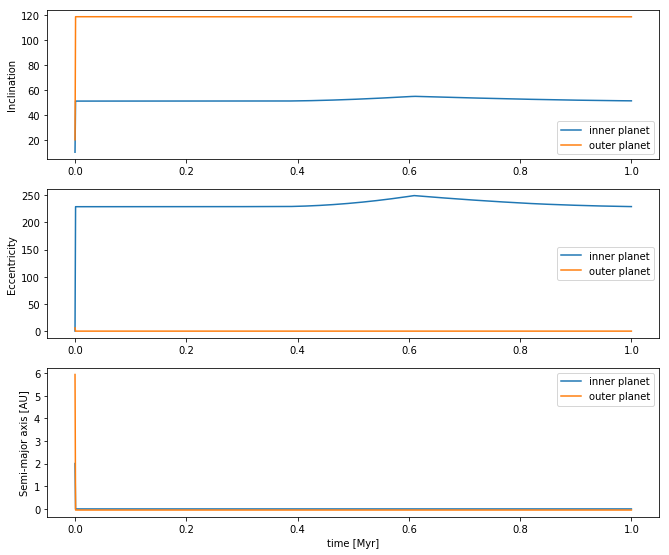

In [229]:
plot_sim(6,2,0.0004772,1000,0.5,0.01,20,10)
plt.savefig('chem1.png')